In [ ]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## Context Offloading: Filesystem

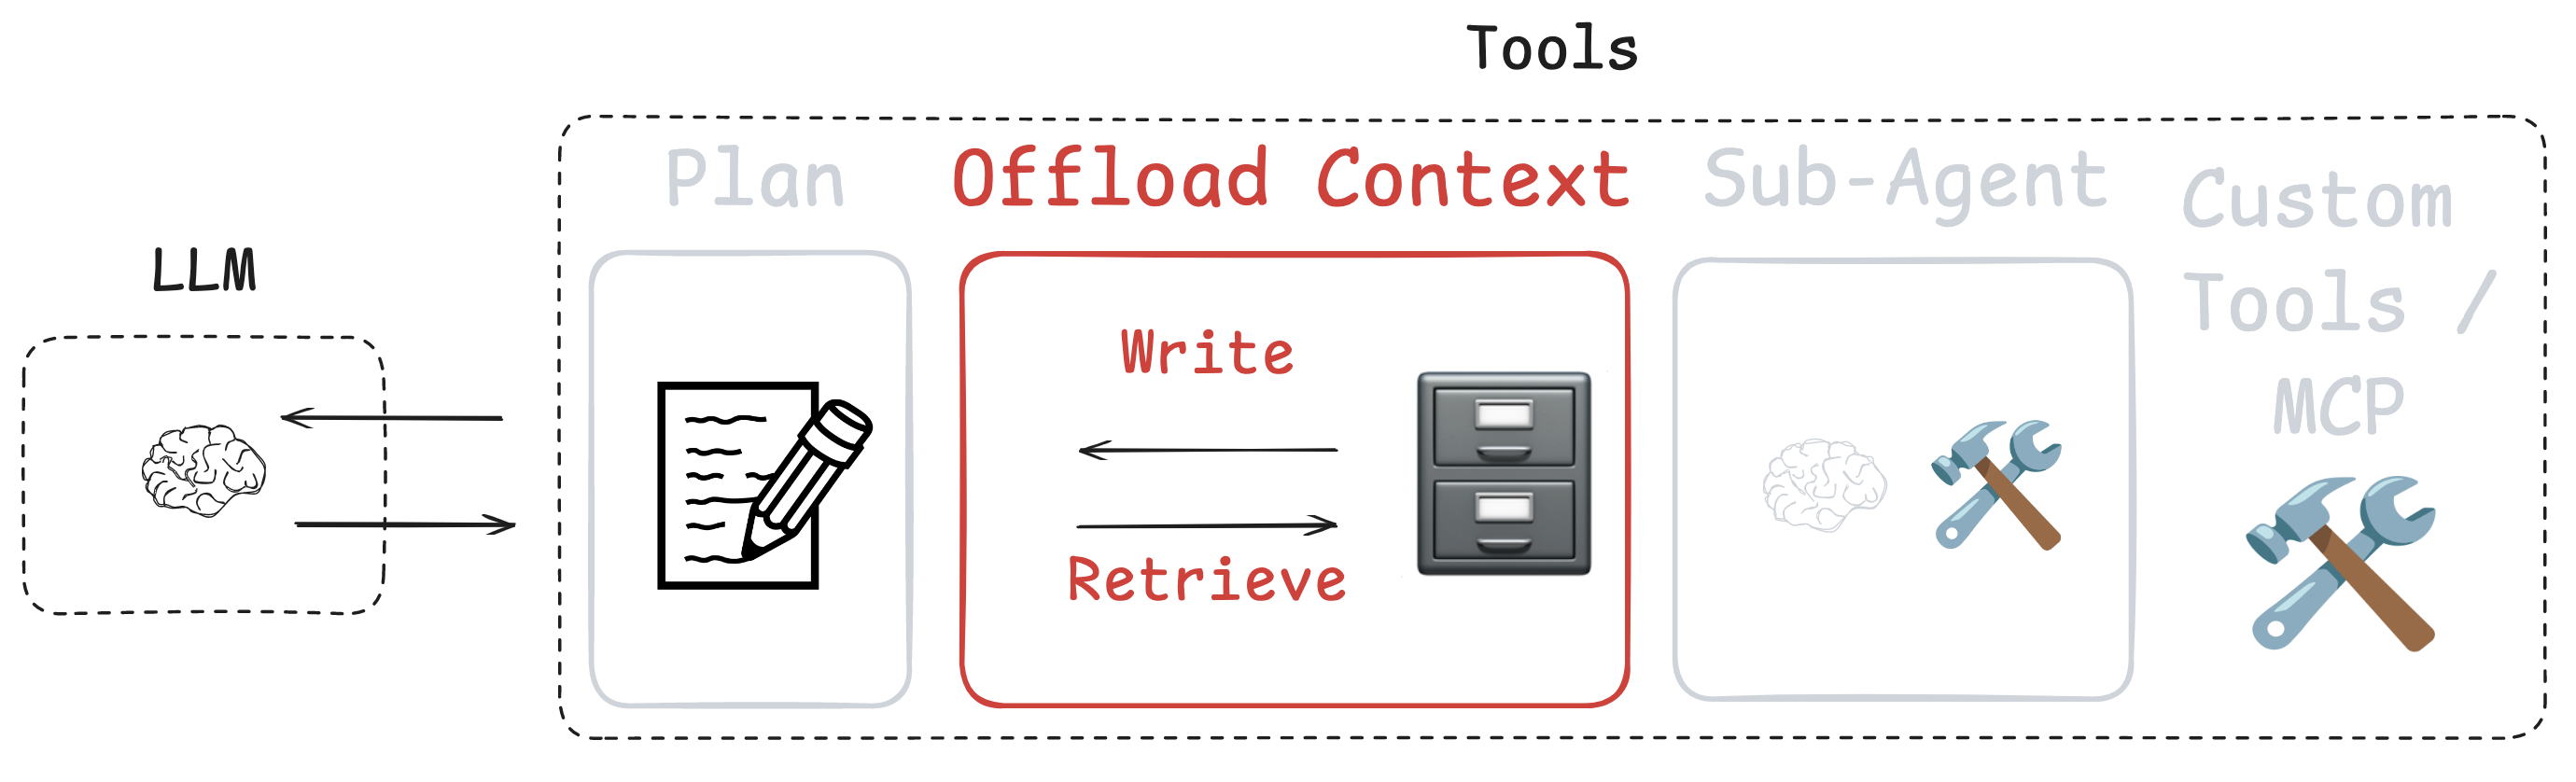

Agent context windows can grow rapidly during complex tasks—the average Manus task uses approximately 50 tool calls, creating substantial context accumulation. A powerful technique for managing this growth is **context offloading** through filesystem operations. Rather than storing all tool call observations and intermediate results directly in the context window, agents can strategically save information to files and [fetch it as-needed](https://blog.langchain.com/context-engineering-for-agents/), maintaining focus while preserving access to critical information.

This approach has been successfully implemented by production systems like [Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and [Hugging Face Open Deep Research](https://huggingface.co/blog/open-deep-research). Anthropic's [multi-agent research system](https://www.anthropic.com/engineering/multi-agent-research-system) provides another compelling example, where subagents store their work in external systems and pass lightweight references back to coordinators. This prevents the "game of telephone" effect—information degradation as it passes through multiple agents—while enabling fresh subagents to spawn with clean contexts and retrieve stored context like research plans from memory when needed.

By writing token-heavy context to files in sandboxed environments, agents can effectively manage memory while maintaining the ability to retrieve detailed information when necessary. This pattern is particularly valuable for structured outputs like code, reports, or data visualizations where specialized prompts produce better results than filtering through general coordinators, and for long-running research tasks where intermediate results need preservation without constant attention.

### Write File Tools

Our implementation uses a virtual filesystem approach that mocks the traditional filesystem within LangGraph state. The core insight is to use a simple dictionary where keys represent mock file paths and values contain the file content. This approach provides short-term, thread-wise persistence that's ideal for maintaining context within a single agent conversation, though it's not suited for information that needs to persist across different conversation threads. The file operations utilize LangGraph's `Command` type to update the agent state, enabling tools to modify the virtual filesystem and maintain proper state management throughout the agent's execution.

**TODO(Geoff)** 

We can explain the tools here in some more detail.

In [2]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)

show_prompt(LS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  List all files in the virtual filesystem stored in agent state.                                                │
│                                                                                                                 │
│  Shows what files currently exist in agent memory. Use this to orient yourself before other file operations     │
│  and maintain awareness of your file organization.                                                              │
│                                                                                                                 │
│  No parameters required - simply call ls() to see all available files.                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
show_prompt(READ_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Read content from a file in the virtual filesystem with optional pagination.                                   │
│                                                                                                                 │
│  This tool returns file content with line numbers (like `cat -n`) and supports reading large files in chunks    │
│  to avoid context overflow.                                                                                     │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path to the file you want to read                                                      │
│  - offset (optional, default=0): Line number to start reading from                                              │
│  - limit (optional, default=2000): Maximum number of lines to read                                              │
│                                                                                                                 │
│  Essential before making any edits to understand existing content. Always read a file before editing it.        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [4]:
show_prompt(WRITE_FILE_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create a new file or completely overwrite an existing file in the virtual filesystem.                          │
│                                                                                                                 │
│  This tool creates new files or replaces entire file contents. Use for initial file creation or complete        │
│  rewrites. Files are stored persistently in agent state.                                                        │
│                                                                                                                 │
│  Parameters:                                                                                                    │
│  - file_path (required): Path where the file should be created/overwritten                                      │
│  - content (required): The complete content to write to the file                                                │
│                                                                                                                 │
│  Important: This replaces the entire file content. Use edit_file for partial modifications.                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**TODO(Geoff)** 

We can add prenameble text here.

In [ ]:
%%writefile ../src/deep_agents_from_scratch/file_tools.py

"""Virtual file system tools for agent state management.

This module provides tools for managing a virtual filesystem stored in agent state,
enabling context offloading and information persistence across agent interactions.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import (
    LS_DESCRIPTION,
    READ_FILE_DESCRIPTION,
    WRITE_FILE_DESCRIPTION,
)
from deep_agents_from_scratch.state import DeepAgentState


@tool(description=LS_DESCRIPTION)
def ls(state: Annotated[DeepAgentState, InjectedState]) -> list[str]:
    """List all files in the virtual filesystem."""
    return list(state.get("files", {}).keys())


@tool(description=READ_FILE_DESCRIPTION)
def read_file(
    file_path: str,
    state: Annotated[DeepAgentState, InjectedState],
    offset: int = 0,
    limit: int = 2000,
) -> str:
    """Read file content from virtual filesystem with optional offset and limit.

    Args:
        file_path: Path to the file to read
        state: Agent state containing virtual filesystem
        offset: Line number to start reading from (default: 0)
        limit: Maximum number of lines to read (default: 2000)

    Returns:
        Formatted file content with line numbers, or error message if file not found
    """
    files = state.get("files", {})
    if file_path not in files:
        return f"Error: File '{file_path}' not found"

    content = files[file_path]
    if not content:
        return "System reminder: File exists but has empty contents"

    lines = content.splitlines()
    start_idx = offset
    end_idx = min(start_idx + limit, len(lines))

    if start_idx >= len(lines):
        return f"Error: Line offset {offset} exceeds file length ({len(lines)} lines)"

    result_lines = []
    for i in range(start_idx, end_idx):
        line_content = lines[i][:2000]  # Truncate long lines
        result_lines.append(f"{i + 1:6d}\t{line_content}")

    return "\n".join(result_lines)


@tool(description=WRITE_FILE_DESCRIPTION)
def write_file(
    file_path: str,
    content: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """Write content to a file in the virtual filesystem.

    Args:
        file_path: Path where the file should be created/updated
        content: Content to write to the file
        state: Agent state containing virtual filesystem
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new file content
    """
    files = state.get("files", {})
    files[file_path] = content
    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(f"Updated file {file_path}", tool_call_id=tool_call_id)
            ],
        }
    )

**Geoff(TODO):** 

We can flesh this text out.

So, now we have a virtual filesystem and tools to work with it. 

Let's illustrate a simple usage example. 

The agent will write the user's request to a file. 

It will then read that request back before answering the user's question!

Note that this simply approach is [very useful with long-running agent trajectories](https://www.anthropic.com/engineering/multi-agent-research-system)! 

In [ ]:
# File usage instructions
FILE_USAGE_INSTRUCTIONS = """You have access to a virtual file system to help you retain and save context.                                  
                                                                                                                
## Workflow Process                                                                                            
1. **Orient**: Use ls() to see existing files before starting work                                             
2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     
3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that you directly answer the user's question."""

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Full prompt
INSTRUCTIONS = (
    FILE_USAGE_INSTRUCTIONS + "\n\n" + "=" * 80 + "\n\n" + SIMPLE_RESEARCH_INSTRUCTIONS
)
show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Read**: Once you are satisfied with the collected sources, read the saved file and use it to ensure that  │
│  you directly answer the user's question.                                                                       │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer    │
│  the user's question.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

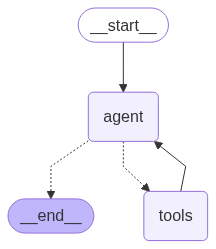

In [12]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.state import DeepAgentState

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [ls, read_file, write_file, web_search]

# Create agent with system prompt
agent = create_react_agent(
    model, tools, prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `files` in state and an user research request. 

In [13]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
        "files": {},
    }
)
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get an overview of Model Context Protocol (MCP). Let me start by checking my current file system  │
│ and then search for information about MCP.                                                                      │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_011Z736HKFXgVUNVuhqE192E                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.txt",                                                                              │
│   "content": "User Request: Give me an overview of Model Context Protocol (MCP).\n\nThe user wants a            │
│ comprehensive overview of Model Context Protocol, including what it is, its purpose, key features, and how it   │
│ works."                                                                                                         │
│ }                                                                                                               │
│    ID: toolu_0136phbcCatB4hCpFDRKxu5B                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.txt                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview what is it purpose features"                                    │
│ }                                                                                                               │
│    ID: toolu_01J7C4w3Ay2yush3wG56pvMb                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_file                                                                                         │
│    Args: {                                                                                                      │
│   "file_path": "user_request.txt"                                                                               │
│ }                                                                                                               │
│    ID: toolu_01CJ6SGoeto51z9ccXfBcYU8                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│      1  User Request: Give me an overview of Model Context Protocol (MCP).                                      │
│      2                                                                                                          │
│      3  The user wants a comprehensive overview of Model Context Protocol, including what it is, its purpose,   │
│ key features, and how it works.                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my search, here's a comprehensive overview of Model Context Protocol (MCP):                            │
│                                                                                                                 │
│ ## What is Model Context Protocol (MCP)?                                                                        │
│                                                                                                                 │
│ Model Context Protocol (MCP) is an **open standard protocol** developed by Anthropic that serves as a           │
│ standardized communication layer between AI models and external systems. It's designed to enable seamless       │
│ integration and data exchange between AI assistants and various external services.                              │
│                                                                                                                 │
│ ## Key Purpose                                                                                                  │
│                                                                                                                 │
│ MCP addresses a fundamental challenge in AI development: **connecting AI models to external data sources and    │
│ tools**. Instead of building custom integrations for each service, MCP provides a unified framework that allows │
│ AI models to:                                                                                                   │
│                                                                                                                 │
│ - Access databases                                                                                              │
│ - Interact with APIs                                                                                            │
│ - Use external tools and services                                                                               │
│ - Retrieve information from various data sources                                                                │
│                                                                                                                 │
│ ## How It Works                                                                                                 │
│                                                                                                                 │
│ MCP acts as a **bridge or translation layer** that:                                                             │
│                                                                                                                 │
│ 1. **Standardizes Communication**: Provides a consistent language and protocol for data exchange                │
│ 2. **Simplifies Integration**: Eliminates the need for custom connectors for each external service              │
│ 3. **Enables Interoperability**: Allows different AI systems to work with the same external resources using the │
│ same protocol                                                                                                   │
│                                                                                                                 │
│ ## Key Benefits                                                                                                 │
│                                                                                                                 │
│ - **Consistency**: One protocol to rule them all - no need to learn different APIs for each service             │
│ - **Efficiency**: Streamlined data access and tool usage for AI models                                          │
│ - **Scalability**: Easy to add new services and tools without rebuilding integrations                           │
│ - **Open Standard**: Being open-source, it promotes wid

We can see the file saved in our mock file system. 

In [14]:
result["files"]

{'user_request.txt': 'User Request: Give me an overview of Model Context Protocol (MCP).\n\nThe user wants a comprehensive overview of Model Context Protocol, including what it is, its purpose, key features, and how it works.'}

Trace: 

https://smith.langchain.com/public/1066102f-d7b3-423c-b556-006865a1d479/r